In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', palette='deep')
pd.options.display.float_format = "{:,.4f}".format

## **Загрузка датасета**

Загрузим полученный на предыдущем шаге тренировочный набор данных *train_data.csv*.

In [139]:
df = pd.read_csv('train_data.csv')

In [140]:
df

,user_id,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,region_id,browser,os,target
0,fb858e8e0a2bec074450eaf94b627fd3,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,470e75,chrome,android,0
1,46a5f128fd569c764a92c2eaa788095e,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,44520b,chrome,android,0
2,5a74e9ac53ffb21a20cce117c0ad77ba,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870,other,yandex,android,0
3,af735816ca19115431ae3d89518c8c91,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,other,chrome,android,0
4,364f0ae0a3f29a685c4fb5bae6033b9a,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,other,yandex,android,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561841,3543d64627ead3a519e3199834e2a148,12332,17481,12664,-984,5146,11562,4316,15017,1423,-981,33ed7a,chrome,android,0
561842,37df5ff1d739f61d442b164db6281e46,13459,-6413,13160,13187,5498,3875,13246,10259,-1630,-14647,97023a,chrome,android,0
561843,b28dbf7b0f2bcbdf01c52715573b93b5,13459,-6413,13160,13187,5498,3875,13246,10259,-1630,-14647,other,chrome,android,0
561844,dd58499b49a3cbb2b5699ac812c6bbc6,18174,17591,3257,2581,8043,13263,2312,1791,9121,5170,unknown,chrome,android,1


## **Обучение и тестирование модели**

Для начала загрузим модель случайного леса.

In [141]:
# ! wget https://raw.githubusercontent.com/kasim-04/user-gender-prediction/main/src/random_forest_from_scratch.py

from random_forest_from_scratch import BinaryRandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

Напишем функцию `predict` для агрегации предсказний для запросов по пользователю.

In [142]:
def predict(model, users, X, threshold=0.5):
    """
    Predicts user-level binary classes by aggregating sample probabilities using the median.

    Parameters
    ----------
    model : object
        A trained classifier implementing the `predict_proba(X)` method.
    users : array-like of shape (n_samples,)
        User identifiers corresponding to each sample.
    X : ndarray of shape (n_samples, n_features)
        Feature matrix for which predictions are made.
    threshold : float, optional, default=0.5
        Probability threshold for assigning the positive class.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with the following columns:
        - `user_id`: the user identifier.
        - `y_pred`: the predicted binary class (0 or 1) based on the median probability.
    """
    y_prob = model.predict_proba(X)

    results = pd.DataFrame({'user_id': users, 'target': y_prob})
    results = results.groupby('user_id')['target'].median().reset_index()
    results['target'] = results['target'].apply(lambda x: 1 if x >= threshold else 0)

    return results

### Подготовка данных к обучение

Разделим данные:
* train - 60%
* val - 20%
* test - 20%

Применим `OrdinalEncoder` к категориальным признакам.

In [143]:
X = df.drop(columns=['user_id', 'target'])
y = df['target']
users = df['user_id']

In [144]:
X_temp, X_test, y_temp, y_test, users_temp, users_test = train_test_split(X, y, users, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val, users_train, users_val = train_test_split(X_temp, y_temp, users_temp, test_size=0.25, random_state=42)

In [145]:
categorical_features = ['region_id', 'browser', 'os']

In [146]:
encoder = OrdinalEncoder()
X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])

In [147]:
X_val[categorical_features] = encoder.transform(X_val[categorical_features])

### Подбор гипперпараметров

Подберем параметр глубины дерева, выбирем лучшую модель по метрике ROC AUC.

In [148]:
from joblib import Parallel, delayed
import itertools

def get_best_params(model_class,
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    users_val,
                    param_grid,
                    score_func,
                    n_estimators=100,
                    threshold=0.5,
                    n_jobs=1,
                    verbose=True):
    """
    Performs parallel hyperparameter search for the given model class
    and selects the parameter combination with the best validation score.

    Parameters
    ----------
    model_class : class
        The model class (e.g., BinaryRandomForestClassifier).
    X_train : array-like
        Feature matrix for training.
    y_train : array-like
        Target values for training.
    X_val : array-like
        Feature matrix for validation.
    y_val : array-like
        Target values for validation.
    users_val : array-like
        List of user identifiers corresponding to samples in `X_val`.
    param_grid : dict
        Dictionary specifying the hyperparameters and their possible values.
    score_func : callable
        Scoring function (e.g., `f1_score`, `accuracy_score`).
    n_estimators : int, default=100
        Number of trees (if applicable to the model).
    threshold : float, default=0.5
        Probability threshold for converting to binary predictions.
    n_jobs : int, default=1
        Number of parallel jobs for training and evaluation.
    verbose : bool, default=True
        Whether to print intermediate results.

    Returns
    -------
    best_params : dict
        The parameter combination that achieved the highest validation score.
    best_score : float
        The best validation score achieved.
    results_df : pandas.DataFrame
        Table with all evaluated parameter combinations and their corresponding scores.
    """
    df_val = pd.DataFrame({'user_id': users_val, 'target': y_val})
    df_true = df_val.groupby('user_id')['target'].first().reset_index()

    keys = list(param_grid.keys())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*param_grid.values())]

    def evaluate_params(params):
        """Train and evaluate model for a given parameter combination."""
        model = model_class(n_estimators=n_estimators, **params)
        model.fit(X_train, y_train)

        df_pred = predict(model, users_val, X_val, threshold=threshold)
        score = score_func(df_true['target'], df_pred['target'])

        if verbose:
            print(f"Params: {params} → Score: {score:.4f}")

        return params, score

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_params)(params) for params in param_combinations
    )
    results_df = pd.DataFrame([
        {**params, 'score': score} for params, score in results
    ])

    best_idx = results_df['score'].idxmax()
    best_params = {k: results_df.loc[best_idx, k] for k in keys}
    best_score = results_df.loc[best_idx, 'score']

    if verbose:
        print("Best parameters:", best_params)
        print("Best score:", f"{best_score:.4f}")

    return best_params, best_score, results_df

In [149]:
n_estimators = 100
param_grid = {'max_depth': [10, 15, 17, 20, 25],
              'min_samples_split': [5],
              'min_samples_leaf': [2],
              'n_bins': [32]}
threshold = 0.5

In [150]:
best_params, best_score, results_df = get_best_params(model_class=BinaryRandomForestClassifier,
                                                     X_train=X_train,
                                                     y_train=y_train,
                                                     X_val=X_val,
                                                     y_val=y_val,
                                                     users_val=users_val,
                                                     param_grid=param_grid,
                                                     score_func=roc_auc_score,
                                                     n_estimators=n_estimators,
                                                     threshold=threshold,
                                                     n_jobs=-1,
                                                     verbose=True)

Best parameters: {'max_depth': np.int64(20), 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(2), 'n_bins': np.int64(32)}
Best score: 0.8044


In [151]:
results_df

,max_depth,min_samples_split,min_samples_leaf,n_bins,score
0,10,5,2,32,0.7834
1,15,5,2,32,0.8002
2,17,5,2,32,0.8026
3,20,5,2,32,0.8044
4,25,5,2,32,0.8036


### Обучение модели

In [158]:
encoder = OrdinalEncoder()
X_temp[categorical_features] = encoder.fit_transform(X_temp[categorical_features])

In [159]:
X_test[categorical_features] = encoder.transform(X_test[categorical_features])

In [160]:
best_model = BinaryRandomForestClassifier(n_estimators=n_estimators, **best_params)
best_model.fit(X_temp, y_temp)

BinaryRandomForestClassifier(max_depth=np.int64(20),
                             min_samples_leaf=np.int64(2),
                             min_samples_split=np.int64(5), n_bins=np.int64(32),
                             n_estimators=100)

### Тестирование модели

In [161]:
df_test = pd.DataFrame({'user_id': users_test, 'target': y_test})

df_true = df_test.groupby('user_id')['target'].first().reset_index()
df_pred = predict(best_model, users_test, X_test, threshold=threshold)

In [162]:
y_true = df_true['target']
y_pred = df_pred['target']

metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'roc_auc': roc_auc_score(y_true, y_pred),
    'precision': precision_score(y_true, y_pred),
    'recall': recall_score(y_true, y_pred),
    'f1': f1_score(y_true, y_pred)
}

for key in metrics:
    print(f'{key}: {metrics[key]:.2f}')

accuracy: 0.81
roc_auc: 0.81
precision: 0.80
recall: 0.80
f1: 0.80


/tmp/ipython-input-1757882263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df, x='importance', y='feature', palette='viridis')


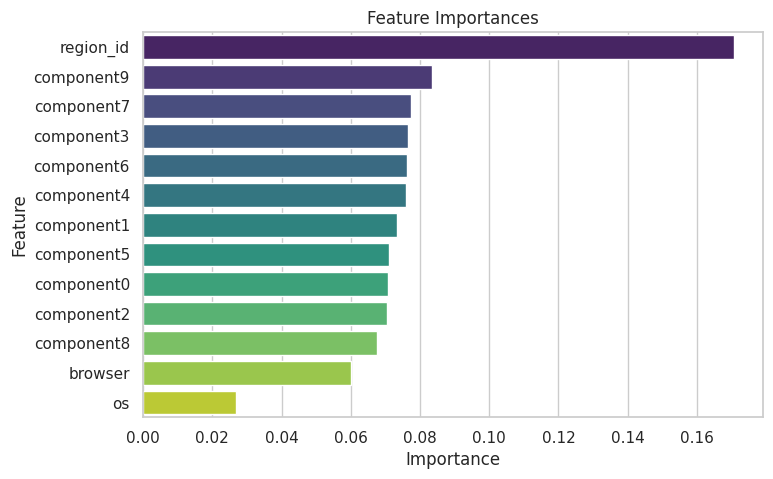

In [163]:
feature_names = X_train.columns

importances_df = pd.DataFrame({'feature': feature_names, 'importance': best_model.feature_importances_})
importances_df = importances_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importances_df, x='importance', y='feature', palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## **Сохранение результатов**

In [ ]:
import joblib

# joblib.dump(encoder, 'encoder.joblib')
# joblib.dump(best_model, 'model.joblib', compress=3)
# pd.DataFrame([metrics]).to_csv('metrics.csv', index=False)
# results_df.to_csv('param_search.csv', index=False)